### LT2326 HT21 Assignment 2 
##### Calvin Kullvén Liao

##### ( The notebook and 3 trained models are also accessible on https://github.com/chickenbror/ml-a2 )

### Preprocess
I made changes to the read_data and convert_to_index functions from the demo, so that the train/test datasets are represented as tuples of (x,y) (so that they can be batch-loaded using DataLoaader), with paddings and start/end tags.

In [34]:
# import sys
# import os
import numpy as np

In [3]:
def read_chinese_data(inputfilename):
    '''
    Reads the input file, returns a list of [(x,y)...], 
    where x = a Chinese sentence string, y = a binary list [1,0...],
    indicating whether a character is the first of a Chinese word.
    Eg, ("這次遊行的特色", [1, 1, 1, 0, 1, 1, 0,]) for 這/次/遊行/的/特色
    '''
    with open(inputfilename, "r") as inputfile:
        xy_list, collection_words, collection_labels = [], [], []
        for line in inputfile:
            if line[0] == '#':
                continue
            columns = line.split()
            if columns == []: # When reading a blank line
                xy_list.append((''.join(collection_words), collection_labels)) # append the (x,y)
                collection_words, collection_labels = [], [] # Reset the x,y lists
                continue
            collection_words.append(columns[1])
            collection_labels += [1] + ([0] * (len(columns[1]) - 1)) # 1 for first char, 0 for the rest
    return xy_list

def get_chars_and_ids(sentences, extra_chars=['<PAD>','<START>','<END>']):
    '''
    Arg:
        sentences: a list of sentence-strings
    Returns:
        list of the character set, plus extras (default: pad, start & end tags), 
        dict of {character:char_id}, tag-and-id by default <PAD>:0, <START>:1, <END>:2
    '''
    char_set = set((char for sen in sentences for char in sen))
    char_list = extra_chars + list(char_set)
    ids_dict = {char:i for i,char in enumerate(char_list)}
    return char_list, ids_dict

def sentence_to_ids(sentence, ids_dict, add_tags=True, padding_len=512): 
    '''Turns a sentence-string into a [ids] array, adds start/end tag by default'''
    
    ids = np.array([ids_dict[char] for char in sentence]) # string to ids
    
    if add_tags and ('<START>' in ids_dict) and ('<END>' in ids_dict):
        start_id, end_id = ids_dict['<START>'], ids_dict['<END>']
        ids = np.pad(ids, (1, 1), 'constant', constant_values=(start_id, end_id)) # pad with start/end tags
    
    pad_id = ids_dict['<PAD>'] if '<PAD>' in ids_dict else len(ids_dict)+1 # pad_id or vocabsize+1
    paddings = np.repeat(pad_id, padding_len - len(ids)+1) # Make sure even the longest sen has one padding
    ids = np.concatenate((ids, paddings))
    return ids

def convert_and_pad(raw_xy_data, ids_dict, y_pad_id=-1):
    '''Turns a list of (sentence, labels) to (padded_sentence_ids, padded_labels)'''
    
    max_len = max((len(x) for x,y in raw_xy_data))+2 # num_chars + 2 tags
    id_and_pad = lambda x : sentence_to_ids(x, ids_dict=ids_dict, padding_len=max_len)
    add_tag_and_pad_y = lambda y : np.concatenate( 
                                        (np.pad(y, 1, 'constant', constant_values=1), # label <start>/<end> as 1
                                         np.repeat(y_pad_id, max_len-len(y)-1) # pads: max_len - len(y)- 2 tags +1
                                        ))
    
    ided_and_padded = ((id_and_pad(x), np.array(len(x)+2), add_tag_and_pad_y(y)) for x,y in raw_xy_data)
    return list(ided_and_padded) # (tagged_and_padded_x, len_x_plus_two_tags, padded_y_plus_two_more_labels)

In [4]:
train_xy_raw = read_chinese_data('/scratch/lt2316-h20-resources/zh_gsd-ud-train.conllu')
test_xy_raw = read_chinese_data('/scratch/lt2316-h20-resources/zh_gsd-ud-test.conllu')

In [5]:
import pandas as pd
pd.DataFrame(train_xy_raw, columns=['x','y'])[:5]

,x,y
0,看似簡單，只是二選一做決擇，但其實他們代表的是你周遭的親朋好友，試著給你不同的意見，但追根究...,"[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
1,其便當都是買來的，就算加熱也是由媽媽負責（後來揭曉其實是避免帶來厄運），父親則在電視台上班。,"[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, ..."
2,這次遊行最大的特色，在於越來越多年輕人上街遊行，而且當中不乏行動激烈的躁少年。,"[1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, ..."
3,懷孕期為421至457日。,"[1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1]"
4,婷婷向昏迷中的婆婆訴說，為什麼生活會與她想像的不一樣。,"[1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, ..."


#### Sandwich x/y between start/end tags and pad to 185 chars long

In [6]:
# set of all chars and their ids
chars_list, ids_dict = get_chars_and_ids((x for x,y in train_xy_raw + test_xy_raw)) 

# Convert (sentence,labels) to (padded ids, len_padded_ids, padded labels)
train_xy = convert_and_pad(train_xy_raw, ids_dict)
test_xy = convert_and_pad(test_xy_raw, ids_dict)

pd.DataFrame(train_xy, columns=['x','x_len','y'])[:5]

,x,x_len,y
0,"[1, 1289, 1477, 1724, 3511, 128, 2476, 1233, 8...",60,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
1,"[1, 1640, 2879, 919, 3021, 1233, 329, 625, 249...",48,"[1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, ..."
2,"[1, 1349, 2371, 3034, 1605, 2805, 835, 2495, 8...",41,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, ..."
3,"[1, 584, 643, 1515, 553, 1703, 567, 66, 37, 17...",15,"[1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, ..."
4,"[1, 2292, 2292, 920, 2793, 75, 1953, 2495, 356...",29,"[1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, ..."


In [157]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Segmenter(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        
        self.emb = nn.Embedding(self.vocab_size, self.emb_size, 0) # padding id = 0
        self.lstm = nn.LSTM(self.emb_size, 150, batch_first=True) # in_size, hidden_size, layers=1
        self.sig1 = nn.Sigmoid()
        self.lin = nn.Linear(150, 2)
        self.softmax = nn.LogSoftmax(2)
        
    def forward(self, x, x_len):
        embs = self.emb(x) # B,185,200
        
        # pack=>lstm=>unpack
        packed = pack_padded_sequence(embs, x_len.to("cpu"), batch_first=True, enforce_sorted=False)
        rnn_output, (_,_) = self.lstm(packed) # B, 185, 150
        unpacked, _ = pad_packed_sequence(rnn_output, batch_first=True)
        
        # sigmoid=>linear 2=>softmax
        output = self.sig1(unpacked) # B, 185, 150
        output = self.lin(output) # B, 185, 150
        output = self.softmax(output) # B, 185, 2
        output = output[:, :max(x_len), :] # outshape B, max_x_len_of_batch(<=184), 2
        return output

In [10]:
from torch.utils.data import DataLoader
import torch.optim as optim

In [159]:
def train_model(train_xy, epochs, device, model, model_fn, batch_size=50, lr=0.005):
    
    m = model.to(device)
    m.train()
    
    batching = DataLoader(train_xy, batch_size=batch_size, shuffle=True)

    loss_fn = nn.NLLLoss(ignore_index=-1) # ignore y padding
    optimizer = optim.Adam(m.parameters(), lr=0.005)
    
    for e in range(epochs):
        total_loss = 0
        for i, (x, x_len, y) in enumerate(batching):
            optimizer.zero_grad()
            
            x, y = x.to(device), y.to(device)
            
            out = m(x, x_len) # B, max_x_len, 2 => permute to B,2,max_x_len
            expect = y[:, :max(x_len)] # B, max_x_len
            
            loss = loss_fn(out.permute(0,2,1), expect) 
            total_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            print(f"Epoch {e+1} avg loss {total_loss/(i+1)}", end='\r')
        print()
        torch.save(m, model_fn)

    return m

In [160]:
vocab_size = len(ids_dict)
model_A_init = Segmenter(vocab_size=vocab_size, emb_size=200)
gpu = 'cuda:3'

model_A = train_model(train_xy, epochs=30, device=gpu, model=model_A_init, model_fn='model_A')

Epoch 1 avg loss 0.40239770635962485
Epoch 2 avg loss 0.21714450158178805
Epoch 3 avg loss 0.16131862122565507
Epoch 4 avg loss 0.12739679208025337
Epoch 5 avg loss 0.10103010442107915
Epoch 6 avg loss 0.08010265226475895
Epoch 7 avg loss 0.063747962843626744
Epoch 8 avg loss 0.052345541305840015
Epoch 9 avg loss 0.042464165366254755
Epoch 10 avg loss 0.036720286798663446
Epoch 11 avg loss 0.034124823776073756
Epoch 12 avg loss 0.031660708738490944
Epoch 13 avg loss 0.024191916862037033
Epoch 14 avg loss 0.018214076897129415
Epoch 15 avg loss 0.013349636929342523
Epoch 16 avg loss 0.010331295733340084
Epoch 17 avg loss 0.0071708931151079025
Epoch 18 avg loss 0.0054092381964437665
Epoch 19 avg loss 0.0039224000211106615
Epoch 20 avg loss 0.0028487879317253836
Epoch 21 avg loss 0.0022939097907510586
Epoch 22 avg loss 0.0019211746766814034
Epoch 23 avg loss 0.0018902905605500564
Epoch 24 avg loss 0.0017987071027164348
Epoch 25 avg loss 0.0017561757726070938
Epoch 26 avg loss 0.00153639079

In [161]:
# Model class must be defined somewhere (no need to give model(*args))
model_A = torch.load('model_A').to('cpu')
model_A.eval()

Segmenter(
  (emb): Embedding(3650, 200, padding_idx=0)
  (lstm): LSTM(200, 150, batch_first=True)
  (sig1): Sigmoid()
  (lin): Linear(in_features=150, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=2)
)

In [162]:
with torch.no_grad():
    test_batching = DataLoader(test_xy, batch_size=10)
    for i,(x,x_len,y) in enumerate(test_batching):
        rawpredictions = model_A(x, x_len)
        break

In [301]:
[ [chars_list[i] for i in sen_ids] for sen_ids in x.detach().tolist()][0]

['<START>',
 '然',
 '而',
 '，',
 '這',
 '樣',
 '的',
 '處',
 '理',
 '也',
 '衍',
 '生',
 '了',
 '一',
 '些',
 '問',
 '題',
 '。',
 '<END>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD

In [302]:
rawpredictions.argmax(2) [0]
# torch.argmax(rawpredictions, 2)

tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])

### Part 1 - Sentence generation (15 points).
Convert the model in Demo 2.1 into a character-based sentence generator. (Strip out the word segmentation objective.)  The model should, given a start symbol, produce a variety of sentences that terminate with a stop symbol (you will have to add these to the data).  The sentences that it generates should be of reasonable average length compared to the sentences in the training corpus (this needn't be precise). 

Report and discuss the changes you made to the notebook using Markdown inside the notebook.

In [215]:
class SentenceGenerator(nn.Module):
    def __init__(self, vocab_size, emb_size=200, lstm_size=150):
        super(SentenceGenerator, self).__init__()
        self.lstm_size = lstm_size
        self.emb_size = emb_size
        self.num_layers = 1
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(self.vocab_size, self.emb_size, padding_idx=0) #V=>200
        
        self.lstm = nn.LSTM( #200=>150
            input_size=self.emb_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            batch_first=True,
#             dropout=0.2,
        )
        
        self.fc = nn.Linear(self.lstm_size, self.vocab_size) #150=>V

    def forward(self, x, hidden_state):
        embed = self.embedding(x) #B,184,200
        output, hidden_state = self.lstm(embed)
        logits = self.fc(output)
        return logits, hidden_state

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new(self.num_layers, batch_size, self.lstm_size).zero_(),
                weight.new(self.num_layers, batch_size, self.lstm_size).zero_())


In [216]:
def train_model_B(train_xy, model, epochs, device, model_fn, batch_size=50):
    model = model.to(device)
    model.train()

    batching = DataLoader(train_xy, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for e in range(epochs):
        total_loss = 0
        
        hidden = model.init_hidden(batch_size)
        
        for i, (x,x_len,_) in enumerate(batching): # y not needed
            optimizer.zero_grad()
            
            hidden = tuple([s.data for s in hidden])
            x = x.to(device)
            
            # output preditions and update hidden state
            predictions, hidden = model(x[:,:max(x_len)], hidden) # B,max_x_len => B,max_x_len,V
            expect = x[:, 1:max(x_len)+1] # next words
            
            loss = criterion(predictions.transpose(1, 2), expect)
            total_loss += loss.item()

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            print(f"epoch {e+1} avg loss: {total_loss/(i+1)}", end='\r')

        print()
        torch.save(model, model_fn)
    return model

In [217]:
vocab_size = len(ids_dict)
model_B_init = SentenceGenerator(vocab_size=vocab_size)
gpu = 'cuda:0'

model_B = train_model_B(train_xy, model=model_B_init, epochs=30, device=gpu, model_fn='model_B')

epoch 1 avg loss: 6.8814031302928935
epoch 2 avg loss: 6.1469741880893715
epoch 3 avg loss: 5.8922610700130465
epoch 4 avg loss: 5.6767599165439635
epoch 5 avg loss: 5.4921111762523656
epoch 6 avg loss: 5.3324235677719125
epoch 7 avg loss: 5.1947582960128785
epoch 8 avg loss: 5.0737626612186435
epoch 9 avg loss: 4.9683668255805975
epoch 10 avg loss: 4.8688516974449155
epoch 11 avg loss: 4.7771672427654276
epoch 12 avg loss: 4.6931721746921545
epoch 13 avg loss: 4.6163374125957495
epoch 14 avg loss: 4.5417279183864595
epoch 15 avg loss: 4.4688791751861575
epoch 16 avg loss: 4.4041201472282415
epoch 17 avg loss: 4.3387535035610215
epoch 18 avg loss: 4.2762805759906775
epoch 19 avg loss: 4.2161924004554745
epoch 20 avg loss: 4.1584902167320255
epoch 21 avg loss: 4.1040454447269445
epoch 22 avg loss: 4.0473456174135215
epoch 23 avg loss: 3.9946828246116646
epoch 24 avg loss: 3.9425329953432082
epoch 25 avg loss: 3.8937939226627353
epoch 26 avg loss: 3.8444074749946595
epoch 27 avg loss: 3.

In [218]:
model_B = torch.load('model_B').to('cpu')
model_B.eval()

SentenceGenerator(
  (embedding): Embedding(3650, 200, padding_idx=0)
  (lstm): LSTM(200, 150, batch_first=True)
  (fc): Linear(in_features=150, out_features=3650, bias=True)
)

In [219]:
def generate_pred_sentence(ids_dict, chars_list, model, text, consider_prev=0):
    model.eval()

    chars = text
    hidden = model.init_hidden(1) #batchsize=1

    while True:
        # (if consider_prev=0 or greater than the nr of chars, the whole sentence so far is considered)
        current_ids = [ids_dict[c] for c in chars[-consider_prev:]] 
        
        x = torch.tensor([current_ids]).long() # Consider <start> ~ last predicted char
        with torch.no_grad():
            y_pred, hidden = model(x, hidden)

        last_char_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_char_logits, dim=0).detach().numpy()
        sample_char_index = np.random.choice(len(last_char_logits), p=p)
        next_char = chars_list[sample_char_index]
#         if next_char == '<PAD>':
#             continue
        chars.append(next_char)
        if next_char=='<END>':
            break

    return chars

In [220]:
print( generate_pred_sentence(ids_dict, chars_list, model=model_B, text=['<START>','這']) )

['<START>', '這', '超', '過', '車', '人', '霸', '於', '1', '9', '1', '9', '年', '所', '有', '開', '始', '才', '公', '司', '（', 'M', '2', '1', '街', '）', '。', '<END>']


In [221]:
def generate_n_sentences(consider_prev, n_sentences = 20, print_sentences=False):

    current_len = 0
    for i in range(n_sentences):
        words = generate_pred_sentence(ids_dict, chars_list, model=model_B, text=['<START>'],
                                      consider_prev=consider_prev)
        
        if print_sentences:
            print(''.join(words), len(words))
        current_len+=len(words)
    print('Avg sentence length:', current_len/n_sentences)

In [222]:
avg_sent_len = np.array([l for x,l,y in train_xy]).mean()
print('Average sentence length in train set:', avg_sent_len)

Average sentence length in train set: 41.10357768326244


In [223]:
# Trying considering different previous nr of chars, and see the avg length of generated sentences
for i in (0,1,5,10,20,30,60,100,150,184):
    print(f'consider the previous {i} characters:', end='\t')
    generate_n_sentences(consider_prev=i)


consider the previous 0 characters:	Avg sentence length: 43.45
consider the previous 1 characters:	Avg sentence length: 1537.9
consider the previous 5 characters:	Avg sentence length: 1075.9
consider the previous 10 characters:	Avg sentence length: 251.05
consider the previous 20 characters:	Avg sentence length: 46.95
consider the previous 30 characters:	Avg sentence length: 35.65
consider the previous 60 characters:	Avg sentence length: 36.95
consider the previous 100 characters:	Avg sentence length: 34.25
consider the previous 150 characters:	Avg sentence length: 32.4
consider the previous 184 characters:	Avg sentence length: 47.1


In [225]:
generate_n_sentences(consider_prev=184, print_sentences=True)

<START>明貝爾龍的常用之一在在當時戰爭，芝加原決onetihaw，她澳慶草加親及黎安城家那山大陸等的印度部，美國空入命令，帝國適合葬有醫動的法之意。<END> 72
<START>但其性也涵到：成為明博基底起。<END> 17
<START>為了什麼音水感強前的重要相對，亦開始由各民族模舉行，一句手段題在內部觀需求神的一個增有相想相關「考嘲升領」，以用禁止釋滅深栓，而陷養獎。<END> 70
<START>中國教宗教育日最皇后措贊拒絕無能在名。<END> 21
<START>以9個經併上，為該國家合票物是你對的陸體寫合作的評死。<END> 29
<START>1890年美國人口普查國戰爭間。<END> 18
<START>報，西藏想雙紅拖入震病，王度將阿廷機別墅人類片選擇。<END> 28
<START>主義和不久，而在這一名管理能比很多時代。<END> 22
<START>公司後仍監獄書至某種和捍國的主要同張副來所有助理和交易擔阻探屍癖結束，更善寫差異的動園。<END> 46
<START>1706年1月完參加，雜夫人Grobires。<END> 25
<START>仍然後來，目前還有以下情在劃碟持，常見拾益的作者夢製技翁繡的肉取代經濟體也有限公司的伊利穹近，倖存得到了2000°及其轉移居。<END> 65
<START>三里時至蕉易的港島和叛明。<END> 15
<START>但期年當26歲更之後，在每21日至1003年10年10月在太·巴黎沙安場開辦了俄米亞堡國家。<END> 48
<START>2000年巴西納加上改為11艘波廿王。<END> 21
<START>簽類和捍：素hielewisty，港島額在紐約22種，戰治以承斌後的代開必須紅光往上手，她下有的貨插圖正案失敗的爭場重慶。<END> 63
<START>巴納斯（Ja結稱為，IGaur，河江蘇劇，俄夏薩爾徐州是李煥、崗、塔o蘭天地街治等8公45系復，僅189的震秀中斯基金融始之間的長田之後，在其文失去規模內容易一段，這種狐擊只有幾天，作化霸素的主編只有關擾。<END> 105
<START>從1994年代表10月1日至18月4日起回了總r亂，香港館進入全找駐守的侵糕。<END> 41
<START>為《神珠》的事會變成，例如生產生於熱場，直徑部打西部故帶，指「火光棍節」之前，SBS和ABA區的

#### Part 1 Report:

I referred to https://www.analyticsvidhya.com/blog/2020/08/build-a-natural-language-generation-nlg-system-using-pytorch/ and defined a next-word-prediction model. In this case, it predicts the next Chinese character based on the previous characters, instead the 'next word' like in English, since a Chinese word can consisting one or multiple characters.

I tried generating sentences by considers different number of previous characters. When only looking back at a few (1~10) characters. The sentences are extremely long and don't make sense, just random combinations of characters.

When considering more and evetually all previous characters, the sentence lengths started to approximate the average length of read sentences in the training set. The overall generated sentences still don't make sense, but they don't look like gibberish anymore. Rather, they look like random 'Chinese words' combined in a somehow grammatical way, at least I can understand some of the words. (Cf from gibberish `Helar touf ghaid moft` to random but intellibible `Because they feel comprehend at foster seedling`).

Moreover, the punctuation is correctly predicted, like the full stop `。` always appearing between the end of a sentence and "\<END>"; the quotation marks `「 ... 」` always apearing together; and four-digit numbers always followed by `年 (year)`.


### Part 2 - Dual objectives (10 points)
Copy the notebook from part 1 and augment the copy by adding back the word segmentation objective, as a second objective with its own loss.  (You could also in theory do Part 1 and Part 2 in reverse, by adding sentence generation with dual objectives first and then stripping out the word segmentation objective; this is equivalent.)  Note that multiple losses can be combined by simple, possibly weighted addition -- backpropagation works entirely correctly on the combined loss.

Report and discuss the changes you made to the notebook using Markdown inside the notebook.

In [240]:
# model(vocabsize)(x, h_state) => out1:[B,maxlen,2] ; out2:([B,maxlen-1,vocabsize], h_state)
class DualModel(nn.Module):
    def __init__(self, vocab_size, emb_size=200, lstm_size=150):
        super(DualModel, self).__init__()
        self.num_layers = 1
        self.lstm_size = lstm_size
        
        # Two model classes
        self.modelA = Segmenter(vocab_size, emb_size)
        self.modelB = SentenceGenerator(vocab_size, emb_size, lstm_size)
    
    def forward(self, x, x_len, hidden_state):
        # original x: B,185
        
        # modelA(x, lengths) => output = segmentation predictions
        output1 = self.modelA(x, x_len)
        
        # modelB(x[:,:max(x_len)], hidden) => outputs = (logits, hidden)
        output2 = self.modelB(x[:,:max(x_len)], hidden_state)
        
        return output1, output2
        
    #====================================================
        
    # Func to initilize a random hidden state  
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new(self.num_layers, batch_size, self.lstm_size).zero_(),
                weight.new(self.num_layers, batch_size, self.lstm_size).zero_())
    

In [241]:
def train_dualmodel(train_xy, model, epochs, device, model_fn, batch_size=50):
    model = model.to(device)
    model.train()

    batching = DataLoader(train_xy, batch_size=batch_size, shuffle=True)
    
    cross_entropy_fn = nn.CrossEntropyLoss(ignore_index=0) # ignore sentence padding
    nll_fn = nn.NLLLoss(ignore_index=-1) # ignore y padding
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for e in range(epochs):
        total_loss = 0
        
        hidden = model.init_hidden(batch_size) # the initial random hidden state
        
        for i, (x, x_len, y) in enumerate(batching):
            optimizer.zero_grad()
            
            hidden = tuple([s.data for s in hidden])
            x, y = x.to(device), y.to(device)
            
            # two outputs 
            out1, out2 = model(x, x_len, hidden)
            
            # output1 loss
            expect1 = y[:, :max(x_len)] # B, max_x_len
            loss1 = nll_fn(out1.transpose(1, 2), expect1)
            
            # output2 loss
            pred, hidden = out2
            expect2 = x[:, 1:max(x_len)+1] # next words
            loss2 = cross_entropy_fn(pred.transpose(1, 2), expect2)
            

            loss = loss1+loss2
            total_loss += loss.item()

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            print(f"epoch {e+1} avg loss: {total_loss/(i+1)}", end='\r')

        print()
        torch.save(model, model_fn)
    return model


In [242]:
vocab_size = len(ids_dict)
dualmodel_init = DualModel(vocab_size=vocab_size)
gpu = 'cuda:3'

dualmodel = train_dualmodel(train_xy, model=dualmodel_init, epochs=30, device=gpu, model_fn='dualmodel')

epoch 1 avg loss: 7.3955021977424625
epoch 2 avg loss: 6.4418727397918705
epoch 3 avg loss: 6.1049072623252875
epoch 4 avg loss: 5.8512919008731845
epoch 5 avg loss: 5.6356389343738565
epoch 6 avg loss: 5.4591644585132645
epoch 7 avg loss: 5.3061556279659275
epoch 8 avg loss: 5.1688736200332645
epoch 9 avg loss: 5.0500814855098735
epoch 10 avg loss: 4.9408833086490635
epoch 11 avg loss: 4.8424501240253455
epoch 12 avg loss: 4.7502390861511235
epoch 13 avg loss: 4.6609840273857115
epoch 14 avg loss: 4.5792471945285795
epoch 15 avg loss: 4.5017314136028295
epoch 16 avg loss: 4.4304992198944095
epoch 17 avg loss: 4.3607246458530425
epoch 18 avg loss: 4.2926826000213625
epoch 19 avg loss: 4.2292533457279215
epoch 20 avg loss: 4.1671144723892215
epoch 21 avg loss: 4.1097656488418585
epoch 22 avg loss: 4.0537209182977686
epoch 23 avg loss: 3.9977472305297855
epoch 24 avg loss: 3.9429872274398803
epoch 25 avg loss: 3.8891284197568897
epoch 26 avg loss: 3.8378148049116136
epoch 27 avg loss: 3.

#### Part 2 Report

Originally I tried to combine both models so they can share the embedding function, but the models have different number of inputs (the SentenceGenerator needs hidden state as input) and internal packing/unpacking, which made the code long and complicated.

In the end I simply call the previous two models as sub-models in the DualModel and calculate their respective output losses with two loss functions (cross entropy vs NLL). The loss of the DualModel is simply the sum of two losses. The pros is that the inputs are the same, the cons is that the x-input needs to be embedded twice since there are two sub-models, but since the inputs and the models are rather light-weight, it did not affect the computing efficiency too much. 

### Part 3 - Analysis (5 points)
You now have three models.  The original word segmentation model, a sentence generation model, and a dual sentence-generation/word segmentation model. 

Compare the performance on the test data of the original word segmentation model between the original objective and the dual objective model.  In how many iterations do the models converge?  What are their final F1 and accuracy scores once they've converged? Are they any different?  If so, why?

Make the same comparison between the sentence generation model and the dual-objective model, except the performance measure is the per-word perplexity on the text corpus.

Report your findings in one of the notebooks.

In [243]:
dualmodel = torch.load('dualmodel').to('cpu')
dualmodel.eval()

DualModel(
  (modelA): Segmenter(
    (emb): Embedding(3650, 200, padding_idx=0)
    (lstm): LSTM(200, 150, batch_first=True)
    (sig1): Sigmoid()
    (lin): Linear(in_features=150, out_features=2, bias=True)
    (softmax): LogSoftmax(dim=2)
  )
  (modelB): SentenceGenerator(
    (embedding): Embedding(3650, 200, padding_idx=0)
    (lstm): LSTM(200, 150, batch_first=True)
    (fc): Linear(in_features=150, out_features=3650, bias=True)
  )
)

#### Comparing Segmenter and the DualModel

In [299]:
# Evaluate Segmenter vs DualModel (output1 only) & compare accuracy/f1
import matplotlib.pyplot as plt

def get_accu_and_f1(collect_preds, collect_golds):
    allpreds, allgolds = torch.cat(collect_preds).float(), torch.cat(collect_golds).float()

    tp = sum(allgolds * allpreds)
    fp = sum(allgolds * (~allpreds.bool()).float())
    tn = sum((~allgolds.bool()).float() * (~allpreds.bool()).float())
    fn = sum((~allgolds.bool()).float() * allpreds)

    accuracy = (tp + tn) / (tp + fp + tn + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = (2 * recall * precision) / (recall + precision)
    
    return accuracy, f1

def train_and_eval(vocab_size, epochs, trainXY, testXY, device, batch_size=50, lr=0.001):
    
    # Train/test batches
    train_batches = DataLoader(train_xy, batch_size=batch_size, shuffle=True)
    test_batches = DataLoader(test_xy, batch_size=batch_size)
    
    # Models
    modelA = Segmenter(vocab_size, 200).to(device)
    modelB = DualModel(vocab_size).to(device)
    
    # Loss funcs & optimizers
    cross_entropy_fn = nn.CrossEntropyLoss(ignore_index=0) # ignore sentence padding
    nll_fn = nn.NLLLoss(ignore_index=-1) # ignore y padding
    optimizerA, optimizerB = optim.Adam(modelA.parameters(), lr=lr), optim.Adam(modelB.parameters(), lr=lr)
    
    
    # Each epoch: train models -> eval models, get accuracy and f1
    all_accuA, all_accuB, all_f1A, all_f1B = [],[],[],[]
    for e in range(epochs):
        hidden = modelB.init_hidden(batch_size) # the initial random hidden state
        
        # TRAIN
        modelA.train(); modelB.train()
        for i, (x, x_len, y) in enumerate(train_batches):
            x, y = x.to(device), y.to(device)
            
            # ====Train A==========================================
            optimizerA.zero_grad()
            
            out = modelA(x, x_len) 
            expect = y[:, :max(x_len)] 
            
            lossA = nll_fn(out.permute(0,2,1), expect) 
            lossA.backward(); optimizerA.step()
            
            
            # ====Train B==========================================
            optimizerB.zero_grad()
            
            hidden = tuple([s.data for s in hidden])
            out1, out2 = modelB(x, x_len, hidden)
            
            # output1 loss
            expect1 = y[:, :max(x_len)] 
            loss1 = nll_fn(out1.transpose(1, 2), expect1)
            # output2 loss
            pred, hidden = out2
            expect2 = x[:, 1:max(x_len)+1] # next words
            loss2 = cross_entropy_fn(pred.transpose(1, 2), expect2)

            lossB = loss1+loss2
            lossB.backward()
            nn.utils.clip_grad_norm_(modelB.parameters(), 1)
            optimizerB.step()
            
        
        # EVAL & TEST
        modelA.eval(); modelB.eval()
        with torch.no_grad():
            
            collect_modelA_preds = []
            collect_modelB_preds = []
            collect_golds = []
            
            hidden = modelB.init_hidden(batch_size) # the initial random hidden state
            
            for i, (x, x_len, y) in enumerate(test_batches):
                x, y = x.to(device), y.to(device) # input-sentence, gold-labels
                
                # ModelA predictions 
                raw_predsA = modelA(x, x_len)
                binary_predsA = raw_predsA.argmax(2)
                
                # ModelB predictions 
                hidden = modelB.init_hidden(batch_size)
                raw_predsB, _ = modelB(x, x_len, hidden) # only need the first output
                binary_predsB = raw_predsB.argmax(2)
                
                #================================
                #Slice off the paddings of predictions/golds
                current_batch_size = x.shape[0]
                for i in range(current_batch_size):
                    collect_modelA_preds.append(binary_predsA[i][:x_len[i]]) 
                    collect_modelB_preds.append(binary_predsB[i][:x_len[i]]) 
                    collect_golds.append(y[i][:x_len[i]])
        
        # Compare predictions of models with golds
        accuracy_A, f1_A = get_accu_and_f1(collect_modelA_preds, collect_golds)
        accuracy_B, f1_B = get_accu_and_f1(collect_modelB_preds, collect_golds)
        
        # Result of current epoch
        all_accuA.append(accuracy_A)
        all_accuB.append(accuracy_B)
        all_f1A.append(f1_A)
        all_f1B.append(f1_B)
        print(f"Training and evaluating Epoch {e+1}", end='\r')
        

    # Draw the line chart
    the_epochs = list(range(1,epochs+1))    

    # Four lines
    plt.plot(the_epochs, all_accuA, label='Segmenter accuracy')
    plt.plot(the_epochs, all_accuB, label='DualModel accuracy')
    plt.plot(the_epochs, all_f1A, label='Segmenter f1')
    plt.plot(the_epochs, all_f1B, label='DualModel f1')
    
    plt.title('Accuracy/F1 over iterations')
    plt.xlabel('epoch')
    plt.ylabel('accuracy & f1')
    plt.legend()
    plt.show()
                
    

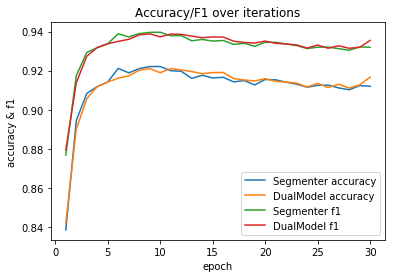

In [300]:
vocab_size = len(ids_dict)

train_and_eval(vocab_size,
               epochs=30, 
               trainXY=train_xy, testXY=test_xy, device='cuda:1')


#### Part 3.1 Report:

The accuracies of the two models converge in around the 4th and 5th epoch and start to stabilise.

The f1s also converge in the same epochs.

Observing from the line chart, the accuracy/f1 of Segmenter fluctuated between epoch 5~20 while the DualModel was more stable. But the accuracy/f1 started to increase when approaching epoch 30, while Segmenter was stable at that point.

In [339]:
def get_perplexity(model, xy_data, device, model_outputs, batch_size=50):

    batches = DataLoader(xy_data, batch_size=batch_size)
    
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    total_losses = torch.tensor([0.0]).to(device)
    
    hidden = model.init_hidden(batch_size)
    for i,(x, x_len, _) in enumerate(batches):
        
        x = x.to(device)
        
        # for single output model
        if model_outputs == 1: 
            output, hidden = model(x[:,:max(x_len)], hidden) # B,max_x_len => B,max_x_len,V
        # for dual output model
        elif model_outputs == 2:
            _, (output, hidden) = model(x, x_len, hidden)
        else:
            return 'model should have either 1 or 2 output(s)'
        
        
        expect = x[:, 1:max(x_len)+1] # next words
        loss = loss_fn(output.transpose(1, 2), expect)

        
        total_losses = torch.cat( (total_losses, loss.reshape(1)) )
        mean_total_loss = torch.mean(total_losses)
        perplexity  = torch.exp(mean_total_loss)

        print(f'Perplexity based on mean loss: {perplexity}', end='\r')

In [347]:
get_perplexity(model_B, test_xy, device='cuda:3', model_outputs=1)

In [348]:
get_perplexity(dualmodel, test_xy, device='cuda:3', model_outputs=2)

#### Part 3.2 Report:
I didn't really understand how to compute the per-word perplexity, and instead found the information on https://stackoverflow.com/questions/59209086/calculate-perplexity-in-pytorch about how to get the perplexity from the cross entropy loss. The loss is computed by iterating the test data over 1 epoch. The perplexity is from the exponential of the mean total loss, as the sum of total loss is too large (calculating it would resulting in an infinite number).

The results showed that the SentenceGenerator model has a much lower perplexity than that of the DualModel.